In [184]:
import numpy as np
import healpy as hp
import scipy as sp
import matplotlib.pyplot as plt

# Problem 1

First, load in the power spectrum example file. Only going to use the first $n_\ell$ values of $\ell$ as scaling up the amount of $\ell$ you use quickly raises computational time.

In [262]:
nl = int(1000.0)
ps = np.loadtxt('../../phys641/problem_sets/example_ps.txt')
ps_1 = ps[:nl,0]

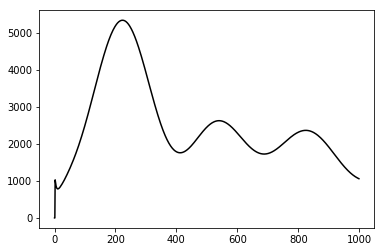

In [263]:
plt.plot(ps_1,c='k')
plt.show()

Now, turn the $\ell (\ell + 1) C_\ell / 2\pi$ into $C_\ell$ by using the appropriate factors. I just set $C_0$ to $0$ as there is a singularity when solving for $C_\ell$ unless I impose that condition. Also note that $\ell = 1$ corresponds to the dipole part of the CMB anisotropies, and the earth's motion with respect to the CMB rest frame dominates this and cannot easily be separated from the dipole caused by structure in early times. Because $C_0$ and $C_1$ are $0$, the corresponding $a_{\ell m}$ will also end up being zero.

In [264]:
inds = np.arange(1,nl)
c_l = ps_1[1:] * 2 * np.pi/(inds*(inds+1))
c_l = np.insert(c_l,0,0)

What should the variance on the map be? Our function is:

$$T(\theta, \phi) = \sum_l \sum_m Y_l^m(\theta, \phi) a_{l m}$$

And we want to find the expected variance over the entire spherical map, $<T^2>$:

\begin{align}
<T^2> &= \frac{1}{4\pi} \int T^2 d\Omega \\
&= \frac{1}{4\pi} \int \sum_{l m} Y_l^m a_{l m} \sum_{l' m'} Y_{l'}^{m' *} a_{l' m'}^* \\
&= \frac{1}{4\pi} \sum_{l m} \sum_{l' m'} a_{l m} a_{l' m'} \int Y_l^m Y_{l'}^{m' *} \\
&= \frac{1}{4\pi} \sum_{l m} \sum_{l' m'} a_{l m} a_{l' m'} \delta_{l l'} \delta_{m m'} \\
&= \frac{1}{4\pi} \sum_{l} \sum_{m} |a_{l m}|^2 \\
&= \frac{1}{4\pi} \sum_{l} (2\ell + 1)C_\ell
\end{align}

So, let's calculate the expected variance and compare later when we've generated a map.

In [265]:
inds = np.arange(0,nl)
expected_var = np.sum(((2*inds+1)*c_l)/(4*np.pi))
print('Expected variance: %.2f' %(expected_var))

Expected variance: 11565.38


Now generate my $a_{\ell m}$. healpix expects l(l+1)/2 $a_{\ell m}$ values: no negative $m$ for any $a_{\ell m}$

In [285]:
nm_max = int((nl+1)*(nl+2)/2)

alm = []
for m in range(nm_max):
    for l in range(0,nl):
        if m <= l & l == 0:
            alm.append(np.random.normal(0,np.sqrt(c_l[l-1])) + 0.j)
        elif m <= l:
            alm.append((1/2**0.5)*np.random.normal(0,np.sqrt(c_l[l-1])) + 
                       (1/2**0.5)*np.random.normal(0,np.sqrt(c_l[l-1]))*1.j)
        else:
            continue

#Don't know monopole information and C_l[0] is 0
alm[0] = 0
alm[1] = 0
alm = np.array(alm,dtype=complex)

With $a_{\ell m}$ in hand, use healpy to turn this into a CMB map.

In [286]:
#When my nside was less than ~half of the number of l, I lost 
#power in the higher l of my generated PS. This kind of intuitively
#makes sense to me - making the map grid cells larger makes the 
#smallest scale structure I can see larger
cmb_map = hp.alm2map(alm,512)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


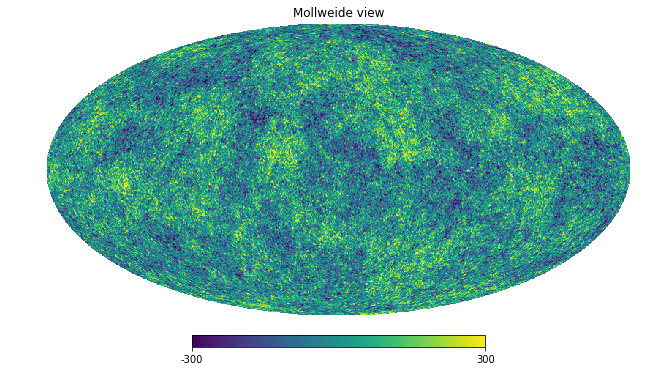

In [287]:
hp.mollview(cmb_map,min=-300,max=300)

Compare the variances

In [288]:
map_var = np.var(cmb_map)
print('Map variance: %.2f'%(map_var))
print('Expected variance: %.2f'%(expected_var))
print('Percentage Difference: %.2f'%(abs((expected_var-map_var)/(map_var + expected_var)/2 * 100)))

Map variance: 11611.51
Expected variance: 11565.38
Percentage Difference: 0.10


Prediction was good! Now turn the generated CMB map into a power spectrum, and compare to the power spectrum that was given

In [289]:
c_l_gen = hp.anafast(cmb_map,lmax=nl-1)

In [290]:
inds = np.arange(0,nl)
ps_gen = inds*(inds+1)*c_l_gen/(2*np.pi)

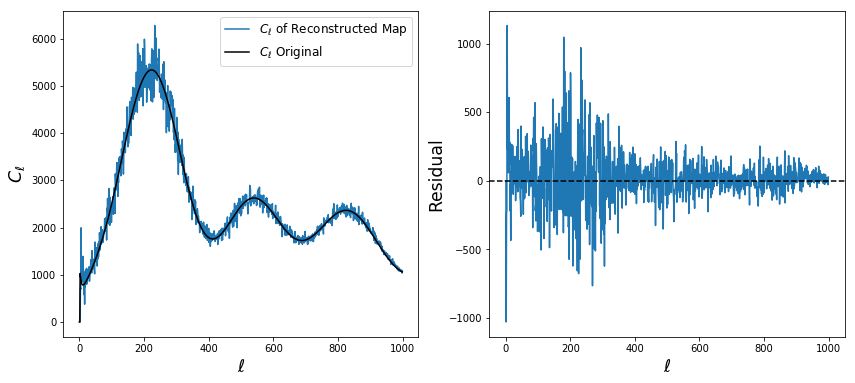

In [291]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.plot(ps_gen, label='$C_\ell$ of Reconstructed Map')
ax1.plot(ps_1, label='$C_\ell$ Original',c='k')
ax1.legend(fontsize='large')
ax1.set_xlabel('$\ell$',fontsize='xx-large')
ax1.set_ylabel('$C_\ell$',fontsize='xx-large')
ax2.plot(ps_gen - ps_1)
ax2.axhline(c='k',ls='--')
ax2.set_xlabel('$\ell$',fontsize='xx-large')
ax2.set_ylabel('Residual',fontsize='xx-large')
plt.show()

The reconstructed power spectrum is in very good qualitative agreement with the provided power spectrum! Now I'll redo the problem but generating my alm with `synalm` and making a map from my $C_\ell$ with `synfast`

In [292]:
cmb_map_gen = hp.synfast(c_l,512)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


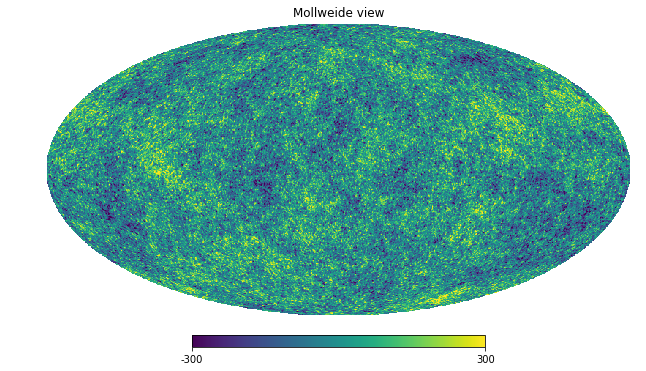

In [293]:
hp.mollview(cmb_map_gen,min=-300,max=300)

In [294]:
c_l_gen2 = hp.anafast(cmb_map_gen,lmax=nl-1)
ps_gen2 = inds*(inds+1)*c_l_gen2/(2*np.pi)

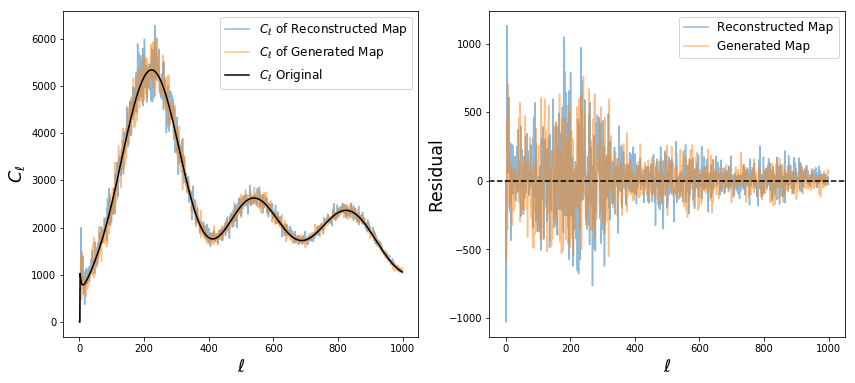

In [295]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,6))
ax1.plot(ps_gen, label='$C_\ell$ of Reconstructed Map',alpha=0.5)
ax1.plot(ps_gen2, label='$C_\ell$ of Generated Map',alpha=0.5)
ax1.plot(ps_1, label='$C_\ell$ Original',c='k')
ax1.legend(fontsize='large')
ax1.set_xlabel('$\ell$',fontsize='xx-large')
ax1.set_ylabel('$C_\ell$',fontsize='xx-large')
ax2.plot(ps_gen - ps_1,label='Reconstructed Map',alpha=0.5)
ax2.plot(ps_gen2 - ps_1,label='Generated Map',alpha=0.5)
ax2.axhline(c='k',ls='--')
ax2.legend(fontsize='large')
ax2.set_xlabel('$\ell$',fontsize='xx-large')
ax2.set_ylabel('Residual',fontsize='xx-large')
plt.show()

The comparison to the input is again good.

# Problem 2

Repeating Question 1, but on a flat sky! Recall from class: $\sim$flat box $x$ radians across on the sky and $Y_\ell^\ell$ has $\ell$ periods across the celestial equator. So, the box will contain one period if $x = 2\pi/\ell$. If $k$ are the modes within our box, then $k=1$ will have one period within the box also: so, $x = 2\pi k/\ell$. The smallest $\ell$ that one could think about going to is the $\ell$ for which there is a period within the box, else the resolution of the box is not enough to capture meaningful information: so $\ell = 2\pi/x$ is the smallest $\ell$ that should be used.

# Appendix

### Questions answered at beginning of class

If $a_{lm}$ real: will get imaginary terms cancelling out in $T(\theta, \phi)$:

$$a_{lm} e^{im\phi} P_{lm} + a_{lm} e^{-im\phi} P_{lm}$$

We know $l = 0$ all have to be real. But in general complex: else will get sky being reflection which is non-physical. Can just make imaginary part of $a_{lm}$ from same distribution as real part